In [289]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as sk
#from path import image_database_path, temp_database_path
import scipy.signal
import os
import sys



# Part1: Localization & image quality selection

In [7]:
# you can change directory to your own path
directory = "C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)"

def readimage(directory, dataset):
    #read image from dataset
    files = []
    for first_sub in os.listdir(directory):
        for second_sub in os.listdir(directory+"/"+first_sub+"/{}".format(dataset) ):
            if second_sub[-3:] == 'bmp':
                files = files + [directory+"/"+first_sub+"/{}".format(dataset) +"/"+second_sub]
    return files

In [8]:
readimage(directory, 1)

['C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/001/1/001_1_1.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/001/1/001_1_2.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/001/1/001_1_3.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/002/1/002_1_1.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/002/1/002_1_2.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/002/1/002_1_3.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/003/1/003_1_1.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/003/1/003_1_2.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/003/1/003_1_3.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/004/1/004_1_1.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/004/1/004_1_2.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/

In [25]:
readimage(directory, 2)

['../CASIA Iris Image Database (version 1.0)/001/2/001_2_1.bmp',
 '../CASIA Iris Image Database (version 1.0)/001/2/001_2_2.bmp',
 '../CASIA Iris Image Database (version 1.0)/001/2/001_2_3.bmp',
 '../CASIA Iris Image Database (version 1.0)/001/2/001_2_4.bmp',
 '../CASIA Iris Image Database (version 1.0)/002/2/002_2_1.bmp',
 '../CASIA Iris Image Database (version 1.0)/002/2/002_2_2.bmp',
 '../CASIA Iris Image Database (version 1.0)/002/2/002_2_3.bmp',
 '../CASIA Iris Image Database (version 1.0)/002/2/002_2_4.bmp',
 '../CASIA Iris Image Database (version 1.0)/003/2/003_2_1.bmp',
 '../CASIA Iris Image Database (version 1.0)/003/2/003_2_2.bmp',
 '../CASIA Iris Image Database (version 1.0)/003/2/003_2_3.bmp',
 '../CASIA Iris Image Database (version 1.0)/003/2/003_2_4.bmp',
 '../CASIA Iris Image Database (version 1.0)/004/2/004_2_1.bmp',
 '../CASIA Iris Image Database (version 1.0)/004/2/004_2_2.bmp',
 '../CASIA Iris Image Database (version 1.0)/004/2/004_2_3.bmp',
 '../CASIA Iris Image Dat

In [168]:
def IrisLocalization(image):
    """give a file path to an iris image, return two lists of parameters of the
    inner and outer circles. The first list is the inner circle and the second
    list is the outer circle. The first number is x coordinate of the circle, 
    the second number is the y coordinate, and the last one is the radius of the
    circle."""
    
    # Step 1: Project the image on x-axis and y-axis, the minima are considered 
    # the center of the pupil.
    
    #plt.imshow(image)
    #plt.show()
    xp = np.argmin(np.sum(image, axis=0)[100:180])+100
    yp = np.argmin(np.sum(image, axis=1)[100:180])+100
    
    
    # Step 2: Find a reasonable threshold to find a more accurate pupil 
    # coordinates. Repeat the step twice for a more accurate estimate.
    
    for i in range(2):
        region = image[yp-60:yp+60, xp-60:xp+60]
        retval, dst = cv2.threshold(region, 65, 1, cv2.THRESH_BINARY)
        mask = np.where(dst != 0, 1, 0)
        xp += np.argmin(np.sum(mask, axis=0)) - 60
        yp += np.argmin(np.sum(mask, axis=1)) - 60
    
    # Step 3: Use Canny edge detection and Hough transform to find two circles.
    
    # set two smaller regions to detect edges faster
    width1 = 70
    region_inner = image[max(0, yp-width1):min(280, yp+width1), 
                       max(0, xp-width1):min(320, xp+width1)]
    width2 = 125
    region_outer = image[max(0, yp-width2):min(280, yp+width2), 
                       max(0, xp-width2):min(320, xp+width2)]
    
    # get two parameters for canny edge detection for the inner circle
    var = 0.33
    median = np.median(region_inner)
    para1 = int(max(0, (1.0 - var) * median))
    para2 = int(min(255, (1.0 + var) * median))
    
    # remove noise caused by eye lashes
    inner_filter = cv2.bilateralFilter(region_inner,9,95,95) 
    # use canny edge detector to get an image of inner boundary
    edged_inner = cv2.Canny(inner_filter, para1, para2)
    inner_circles = cv2.HoughCircles(edged_inner, cv2.HOUGH_GRADIENT, 1,300, 
                                     param1=50, param2=10, minRadius=25, 
                                     maxRadius=58)
    region_outer = cv2.bilateralFilter(region_outer,9,95,95) 
    outer_circles = cv2.HoughCircles(region_outer, cv2.HOUGH_GRADIENT, 1,300, 
                                     param1=30, param2=10, minRadius=95, 
                                     maxRadius=114)
    
    # draw circles
    # pupil boundary
    for i in inner_circles[0,:]:
        inner_circle = [int(i[0])+xp-width1, int(i[1])+yp-width1, i[2]]
    # iris boundary
    for i in outer_circles[0,:]:
        outer_circle = [int(i[0])+xp-width2, int(i[1])+yp-width2, i[2]]
    #plt.imshow(image)
    #plt.show()
    return (inner_circle, outer_circle)

In [169]:
def find_roi(img, with_boundary=False):
    # Find two regions on each side of the pupil
    # If within_boundary == True, return the side length of these regions(for ajustable f[i])
    inner_x, inner_y, inner_r = map(int, map(int, IrisLocalization(img)[0]))

    outer_x, outer_y, outer_r = map(int, map(int, IrisLocalization(img)[1]))


    area_1_x = max(0, inner_x-inner_r-60)
    area_2_x = inner_x+inner_r
    area_y = inner_y - 30
    area_1_h = 60
    area_2_h = 60
    
   
    area1 = img[area_y:(area_y+60), area_1_x:(area_1_x+60)]

    area2 = img[area_y:(area_y+60), area_2_x:(area_2_x+60)]
    if with_boundary == False:
        return area1, area2
    else:
        boundary_dict = {'area_1_h':area_1_h, 'area_2_h':area_2_h}
        return area1, area2, boundary_dict
    

In [170]:
def draw_roi(img, name):
    #draw the ROIs on img
    inner_x, inner_y, inner_r = map(int, map(int, IrisLocalization(img)[0]))

    outer_x, outer_y, outer_r = map(int, map(int, IrisLocalization(img)[1]))


    
    area_1_x = max(0,inner_x-inner_r-64)
    area_2_x = inner_x+inner_r
    area_y = inner_y - 30
    area_1_h = 60
    area_2_h = 60
    
    
    
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.circle(img_bgr, (inner_x, inner_y), inner_r, (255, 0, 0), 2)
    cv2.circle(img_bgr, (outer_x, outer_y), outer_r, (255, 0, 0), 2)
    cv2.rectangle(img_bgr, (area_1_x, area_y), (area_1_x+area_1_h, area_y+area_1_h), (0, 255, 0), 2)
    cv2.rectangle(img_bgr, (area_2_x, area_y), (area_2_x+64, area_y+area_1_h), (0, 255, 0), 2)
    #cv2.imwrite(name, img_bgr)
    plt.figure(figsize=(5, 5))
    plt.imshow(img_bgr, 'gray')
    plt.title(name)
    

In [171]:
def integ_calc(f_abs, f1, f2):
    #Calculate the integration
    integ = 0
    for u in range(f_abs.shape[0]):
        for v in range(f_abs.shape[1]):
            if f1 <= np.sqrt(np.square(u-30)+np.square(v-30)) <= f2 :
                integ += f_abs[u, v]
    return integ

In [172]:
def feature_calc(img, area_h = None):
    #Calculate the 2D feature 
    f = np.abs(np.fft.fft2(img))
    f_abs = np.abs(np.fft.fftshift(f))
    if area_h == None:
        f = [0, 6, 22, 32]
    else:
        f = [0, area_h*3/32, area_h*11/32, area_h/2]
    F1 = integ_calc(f_abs, f[0], f[1] )
    F2 = integ_calc(f_abs, f[1], f[2])
    F3 = integ_calc(f_abs, f[2], f[3])
    
    return np.array([(F1 + F2 + F3), (F2 / (F1 + F3))])

In [201]:
file_name_list = readimage(directory, 1) + readimage(directory, 2)

file_name_list

['C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/001/1/001_1_1.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/001/1/001_1_2.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/001/1/001_1_3.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/002/1/002_1_1.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/002/1/002_1_2.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/002/1/002_1_3.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/003/1/003_1_1.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/003/1/003_1_2.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/003/1/003_1_3.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/004/1/004_1_1.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/004/1/004_1_2.bmp',
 'C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/

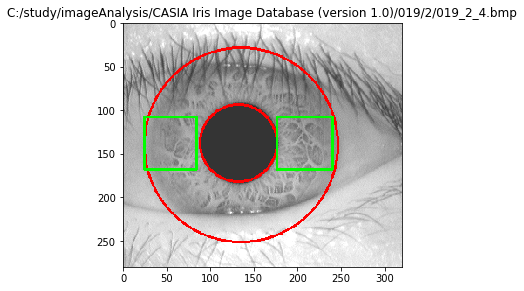

In [202]:
#Example:
#You can change i
file_name = file_name_list[399]
img = cv2.imread('%s' %  file_name,0)
draw_roi(img, file_name)

[array([1.72533119e+06, 5.46520054e-01]),
 array([1.77024354e+06, 5.63880581e-01]),
 array([1.82566672e+06, 5.40865872e-01]),
 array([1.69642105e+06, 5.15041990e-01]),
 array([1.70085169e+06, 5.13749113e-01]),
 array([1.84063917e+06, 5.55596059e-01]),
 array([2.08710694e+06, 6.36232312e-01]),
 array([2.06955492e+06, 6.18125144e-01]),
 array([2.07319248e+06, 6.36486544e-01]),
 array([2.46059719e+06, 7.71966764e-01]),
 array([2.40650646e+06, 7.22079181e-01]),
 array([2.52867269e+06, 7.68500741e-01]),
 array([1.85160899e+06, 5.35284853e-01]),
 array([2.43085871e+06, 6.98847482e-01]),
 array([2.36590151e+06, 6.87033521e-01]),
 array([1.72891853e+06, 5.37421684e-01]),
 array([1.93859341e+06, 5.89145842e-01]),
 array([1.77164545e+06, 5.51738306e-01]),
 array([2.17708341e+06, 6.22569615e-01]),
 array([2.14912734e+06, 6.16637457e-01]),
 array([2.28052991e+06, 6.15109148e-01]),
 array([2.31250244e+06, 6.42714236e-01]),
 array([2.05214841e+06, 6.10870265e-01]),
 array([2.25914556e+06, 6.37754240

In [270]:
Mean = np.mean(np.asarray(X),axis = 0)
Sd = np.std(np.asarray(X),axis = 0)




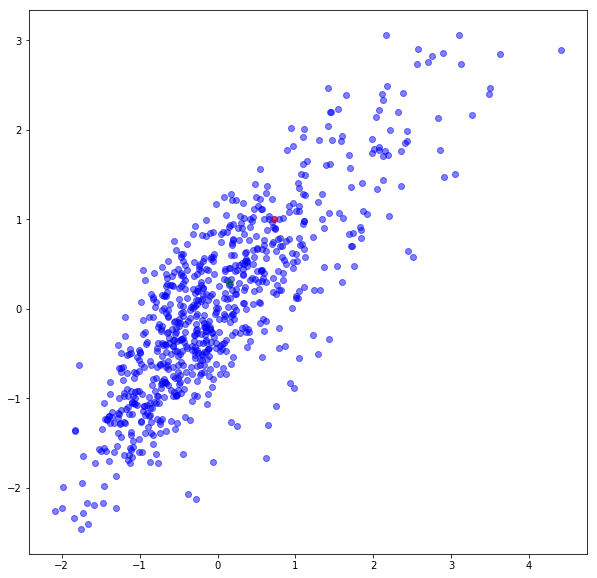

In [283]:
from sklearn import preprocessing

X_scaled = preprocessing.scale(X, axis=0)


plt.figure(figsize=(10, 10))
plt.scatter(x=X_scaled[:, 0],y= X_scaled[:, 1], color='b', alpha=0.5 )
plt.scatter(x=X_scaled[8, 0],y= X_scaled[8, 1], color='r', alpha=0.5 )
plt.scatter(x=km.cluster_centers_[0,0],y= km.cluster_centers_[0,1], color='g', alpha=0.5 )
plt.show()
#can not be well clustered.

[[ 0.14960738  0.29951326]
 [ 1.88008581  1.6618254 ]
 [-0.81386408 -0.92157509]]


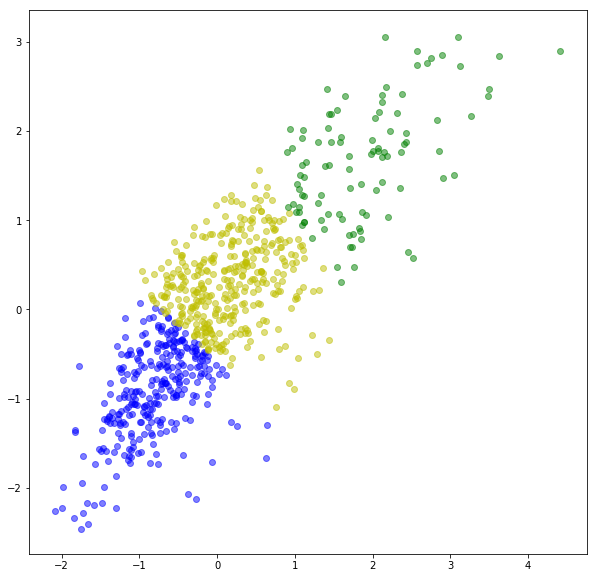

In [205]:
#k-means clustering
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)
km.fit(X_scaled)
label_km = km.labels_

types = []
for x in label_km:
    if x not in types:
        types.append(x)

cValue = ['r','y','g','b','r','y','g','b','r'] 

plt.figure(figsize=(10, 10))
for t in types:
    X_ = X_scaled[label_km == t]
    plt.scatter(x=X_[:, 0], y=X_[:, 1], color=cValue[t+1], alpha=0.5 )
print(km.cluster_centers_)
# diveded into Occluded, Clear, Blurred.

In [266]:
def readimage_0(directory, first_sub,dataset):
    files = []
    for second_sub in os.listdir(directory+"/"+first_sub+"/{}".format(dataset) ):
        if second_sub[-3:] == 'bmp':
            files = files + [directory+"/"+first_sub+"/{}".format(dataset) +"/"+second_sub]
    return files


def quality_accessment(file_name_list):
    X = []
    for file_name in file_name_list:
        img = cv2.imread(file_name,0)
        area1, area2 = find_roi(img)
        x1 = feature_calc(area1)
        x2 = feature_calc(area2)
        x = np.mean((x1, x2), axis=0)
        X.append(x)
    

    X = np.asarray(X)
    X_clear = km.cluster_centers_[0]*Sd+Mean

    best_index =  np.argmin(np.linalg.norm(X-X_clear,axis=1))
    print(file_name_list[best_index])
    return file_name_list[best_index]

In [267]:
best_1 = []
first_subs = os.listdir(directory)
for first_sub in first_subs:
    file_names = readimage_0(directory, first_sub, 1)
    best_1.append(quality_accessment(file_names))

C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/001/1/001_1_3.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/002/1/002_1_3.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/003/1/003_1_2.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/004/1/004_1_2.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/005/1/005_1_1.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/006/1/006_1_2.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/007/1/007_1_2.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/008/1/008_1_2.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/009/1/009_1_3.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/010/1/010_1_2.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/011/1/011_1_1.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/012/1/012_1_3.bmp
C:/study/imageAnalysis/CASIA

C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/103/1/103_1_2.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/104/1/104_1_2.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/105/1/105_1_2.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/106/1/106_1_3.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/107/1/107_1_2.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/108/1/108_1_3.bmp


In [323]:
best_2 = []
first_subs = os.listdir(directory)
for first_sub in first_subs:
    file_names = readimage_0(directory, first_sub, 2)
    best_2.append(quality_accessment(file_names))

C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/001/2/001_2_3.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/002/2/002_2_4.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/003/2/003_2_2.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/004/2/004_2_4.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/005/2/005_2_2.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/006/2/006_2_3.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/007/2/007_2_3.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/008/2/008_2_4.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/009/2/009_2_1.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/010/2/010_2_1.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/011/2/011_2_4.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/012/2/012_2_4.bmp
C:/study/imageAnalysis/CASIA

C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/103/2/103_2_4.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/104/2/104_2_3.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/105/2/105_2_4.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/106/2/106_2_1.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/107/2/107_2_4.bmp
C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/108/2/108_2_2.bmp


# Part2: Image Processing

In [608]:
def IrisNormalization(circle_p, circle_i,image,theta = 0):
    """give the return value of IrisLocalization, return the normalized image, 
    which is 64*512 """
    
    mapx = np.ndarray((64,512),dtype=np.float32)
    mapy = np.ndarray((64,512),dtype=np.float32)
    for i in range(64):
        for j in range(512):
            theta1 = (2*np.pi*j/1024)+theta-np.pi/2
            ratio = i/128
            xp = circle_p[0]+circle_p[2]*np.sin(theta1)
            yp = circle_p[1]+circle_p[2]*np.cos(theta1)
            xi = circle_i[0]+circle_i[2]*np.sin(theta1)
            yi = circle_i[1]+circle_i[2]*np.cos(theta1)
            mapx[i,j] = xp+ratio*(xi-xp)
            mapy[i,j] = yp+ratio*(yi-yp)
    result = cv2.remap(image,mapx,mapy,cv2.INTER_LINEAR)
    return result


def ImageEnhancement(image):
    """give the normalized image, return an enhanced image"""
    
    # Step1: Take average of 16*16 window as approx. illumination
    #illum = np.ndarray((4,32),dtype = np.float32)
    #for i in range(4):
    #    for j in range(32):
    #        illum[i,j] = np.sum(image[(16*i):(16*(i+1)),(16*j):(16*(j+1))])/256
            
    # Step2: Expand the illumination size to 64*512 by bicubic interpolation.
    #illum_whole = cv2.resize(illum, None,fx=16, fy=16, interpolation=cv2.INTER_CUBIC)
    
    # Step3: Subtract the illumination to compensate for lighting conditions.
    #for i in range(64):
    #    for j in range(512):
    #        image[i, j] -= illum_whole[i, j]
            
    # Step4: Enhance the lighting corrected image by histogram equalization
    
    # Normal histogram equalization
    #equalized_image = cv2.equalizeHist(image)
    for i in range(2):
        for j in range(16):
            image[(32*i):(32*(i+1)),(32*j):(32*(j+1))] = cv2.equalizeHist(image[(32*i):(32*(i+1)),(32*j):(32*(j+1))])
    # Adaptive histogram equalization
    #clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(32,32))
    #equalized_image = clahe.apply(image)
    
    return image

def modulating_function(x, y, f):
    m = np.cos(2*np.pi*f*np.sqrt(x**2+y**2))
    return m

def kernel(x, y, f, sigmaX, sigmaY):
    g = (1/(2*np.pi*sigmaX*sigmaY))*np.exp(-0.5*(x**2/sigmaX**2 + 
                                                 y**2/sigmaY**2))*\
    modulating_function(x, y, f)
    return g

def spatial_filter(f, sigmaX, sigmaY):
    s_filter = np.zeros((8, 8))
    for i in range(8):
        for j in range(8):
            s_filter[i, j] = kernel((-4+j), (-4+i), f, sigmaX, sigmaY)
    return s_filter

def FeatureExtraction(image):
    """give the enhanced image, return the feature vector of the image"""
    
    # Step 1: Find the region of interest.
    roi = image[:48,:]
    
    # Step 2: Get two filtered image.
    filter1 = spatial_filter(0.6, 3, 1.5)
    filtered1 = scipy.signal.convolve2d(roi, filter1, mode='same')
    filter2 = spatial_filter(0.6, 4.5, 1.5)
    filtered2 = scipy.signal.convolve2d(roi, filter2, mode='same')
    
    #Step 3: Get the feature vector.
    feature_vec = np.zeros(1536)
    for i in range(2):
        filtered = [filtered1, filtered2][i]
        for j in range(6):
            for k in range(64):
                mean = np.mean(abs(filtered[j*8:(j+1)*8, k*8:(k+1)*8]))
                sd = np.mean(abs(abs(filtered[j*8:(j+1)*8, k*8:(k+1)*8])- mean))
                feature_vec[i*768 + 128*j + 2*k] = mean
                feature_vec[i*768 + 128*j + 2*k + 1] = sd        
    return feature_vec.reshape(1,-1)

<function matplotlib.pyplot.show(*args, **kw)>

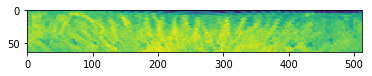

In [609]:
img = cv2.imread("C:/study/imageAnalysis/CASIA Iris Image Database (version 1.0)/001/1/001_1_3.bmp",0)
inner_c, outer_c = IrisLocalization(img)
test = IrisNormalization(inner_c, outer_c, img)
plt.imshow(test)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

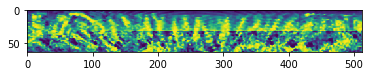

In [610]:
test1 = ImageEnhancement(test)
plt.imshow(test)
plt.show

In [611]:
def findfeature(file,theta = 0):
    img = cv2.imread(file,0)
    inner_c, outer_c = IrisLocalization(img)
    test = IrisNormalization(inner_c, outer_c, img,theta)
    abc = ImageEnhancement(test)
    feature = FeatureExtraction(abc)
    return(feature)
  



In [612]:
features = np.ndarray(shape=(0,1536))
for file in best_1:
    features =  np.concatenate((features,findfeature(file)) ,axis=0)

In [614]:
result = []
for file in best_2[5:10]:
    thefeature = np.ndarray(shape=(0,1536))
    for angle in angles:
        thefeature =  np.concatenate((thefeature,findfeature(file,angle)) ,axis=0)
    result.append(np.argmax(sk.pairwise.cosine_similarity(features,thefeature))//5 +1)
result

[6, 107, 69, 9, 61]

In [596]:
sum(np.array(result) == np.arange(108)+1)/108

0.12037037037037036

In [496]:
thefeature = np.ndarray(shape=(0,1536))
for angle in angles:
        thefeature =  np.concatenate((thefeature,findfeature(best_1[3],angle)) ,axis=0)

In [471]:
result = []
for file in best_2[:10]:
    result.append(np.argmax(sk.pairwise.cosine_similarity(features,findfeature(file)))+1)
result

[0, 93, 2, 89, 105, 5, 93, 46, 44, 106]